# Trivial test of Boltzman generator functionality

In [1]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
import sys
sys.path.insert(0,'..')

from boltzmann_generator import BoltzmannGenerator
from energy_models.normal_distribution import NormalDistribution

### Create simple BG
- Create BG with just one RealNVP block and plot its topology.
- It will be trained to sample 10-dimensional vectors from isotropic normal distribution.
- Note that topology is quite compliated even in this simple case.

In [3]:
dim = 10
sigma = 10

In [4]:
normal_distribution_model = NormalDistribution(dim, sigma)
bg = BoltzmannGenerator(
    layers='R', 
    energy_model=normal_distribution_model,
)

Layers of invertible NN: <R>
< 10 0 0
R 5 5 0
> 5 5 0


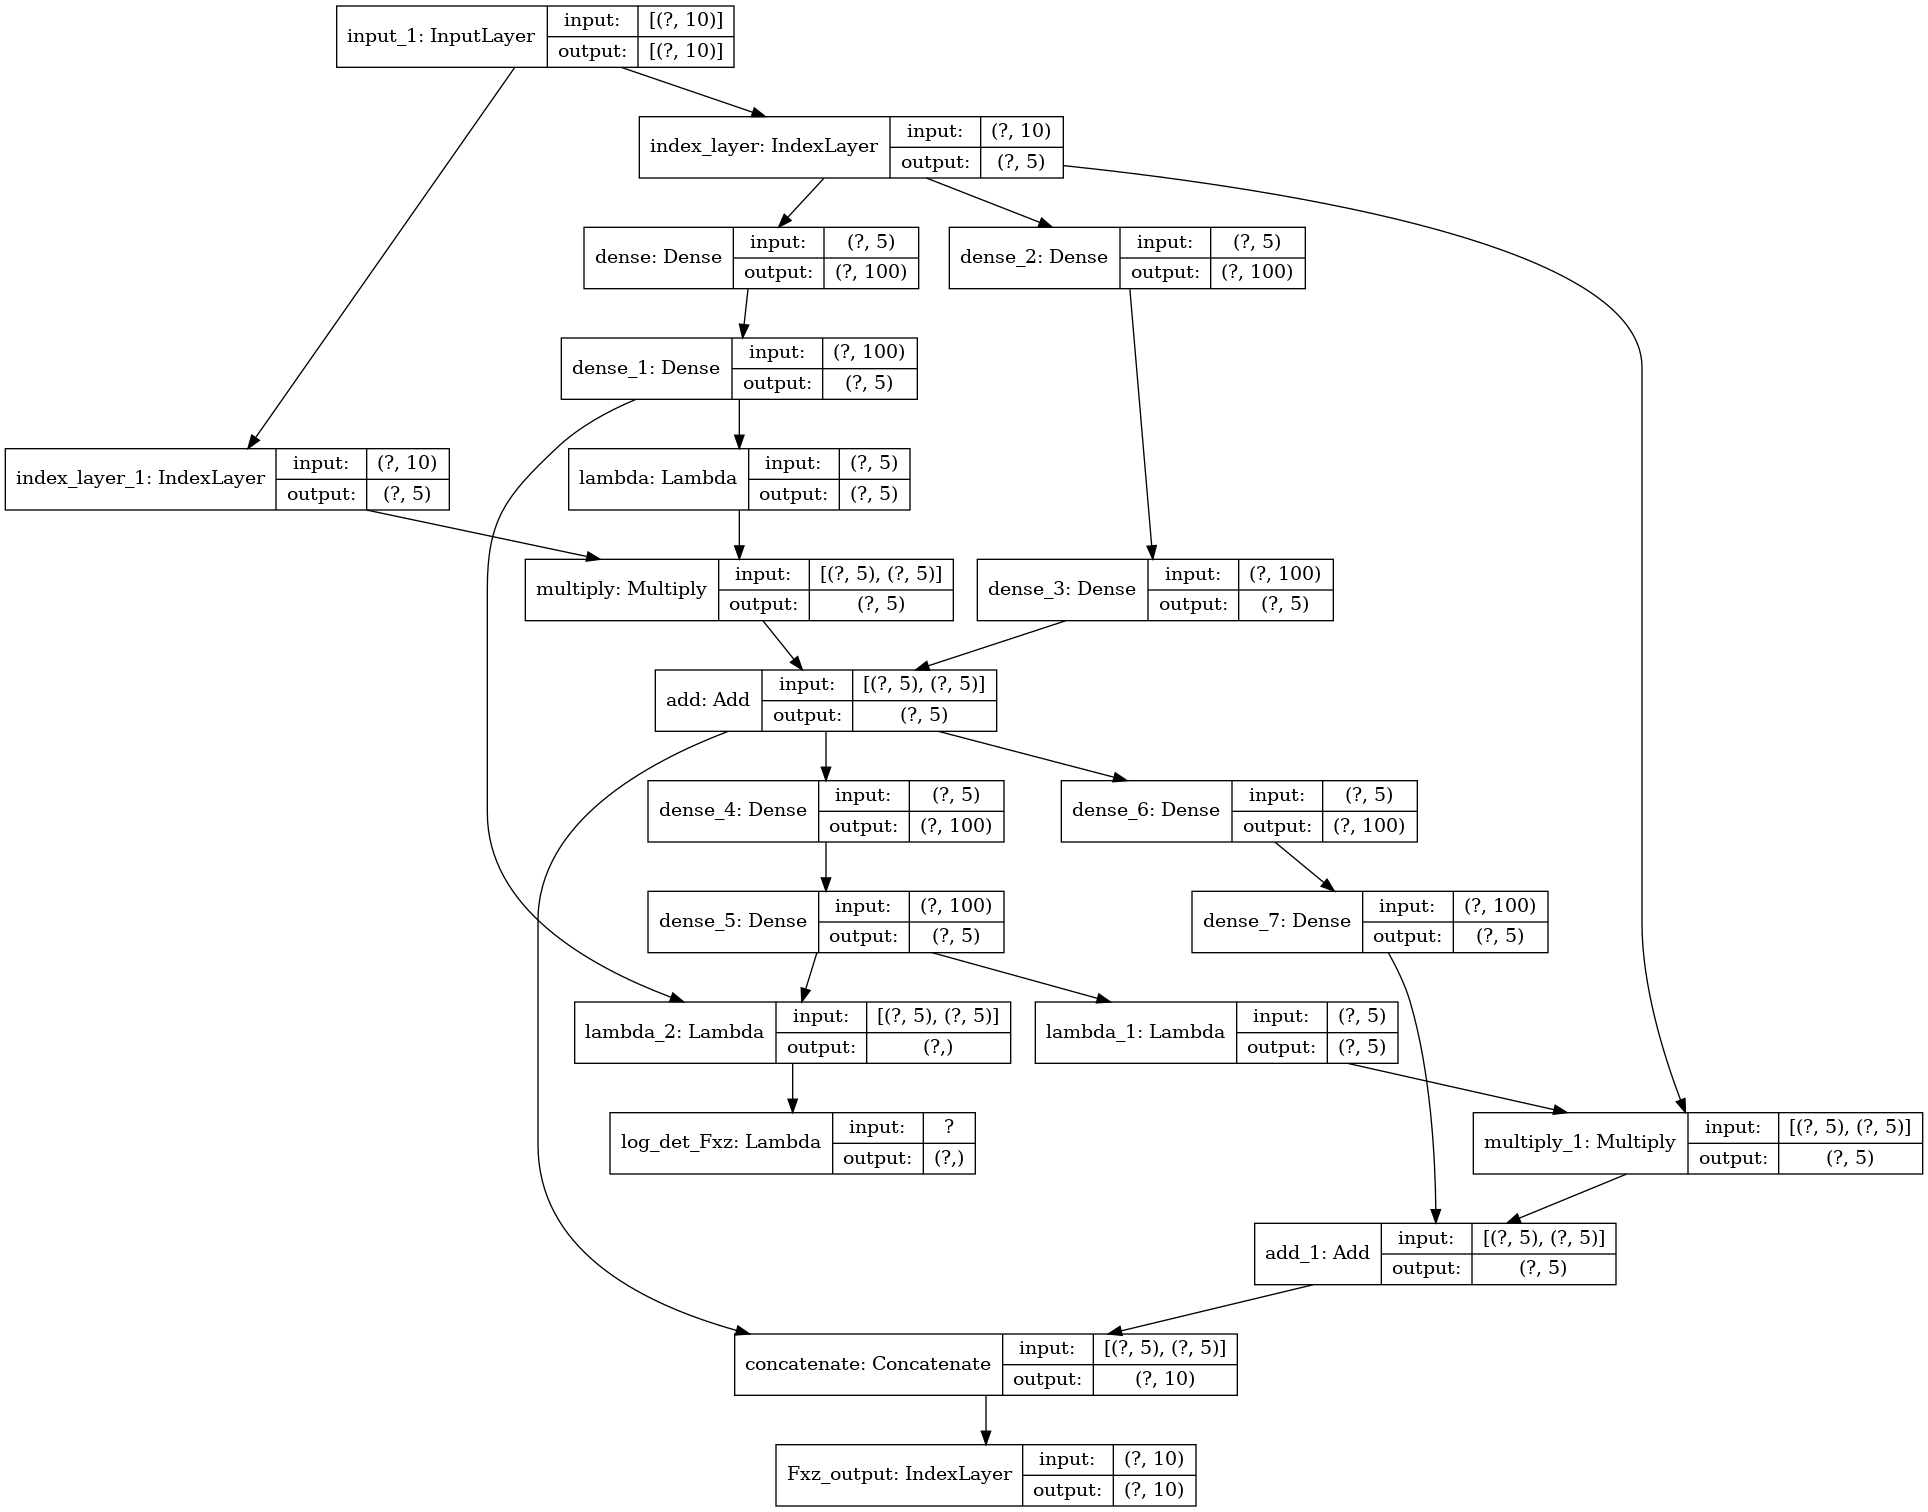

In [5]:
tf.keras.utils.plot_model(
    bg.FxzJ, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [6]:
bg.FzxJ.summary()

Model: "FzxJ"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
index_layer_3 (IndexLayer)      (None, 5)            0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 100)          600         index_layer_3[0][0]              
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100)          600         index_layer_3[0][0]              
_______________________________________________________________________________________________

## Train BG to produce gaussian distribution
### Test training by example
- Training set consists of 50 000 random samples from 10-dimensional isotropic normal distribution 

Mean: -0.0007140760456769742 St. dev.:  9.993634120615663
Iteration 0/150: loss: 534.2075 ML_loss: 534.2075 
Iteration 10/150: loss: 499.4210 ML_loss: 499.4210 
Iteration 20/150: loss: 457.3044 ML_loss: 457.3044 
Iteration 30/150: loss: 449.8891 ML_loss: 449.8891 
Iteration 40/150: loss: 418.4083 ML_loss: 418.4083 
Iteration 50/150: loss: 406.8417 ML_loss: 406.8417 
Iteration 60/150: loss: 398.4692 ML_loss: 398.4692 
Iteration 70/150: loss: 396.6272 ML_loss: 396.6272 
Iteration 80/150: loss: 364.2984 ML_loss: 364.2984 
Iteration 90/150: loss: 340.0209 ML_loss: 340.0209 
Iteration 100/150: loss: 326.5689 ML_loss: 326.5689 
Iteration 110/150: loss: 324.0246 ML_loss: 324.0246 
Iteration 120/150: loss: 284.4322 ML_loss: 284.4322 
Iteration 130/150: loss: 256.5049 ML_loss: 256.5049 
Iteration 140/150: loss: 213.7775 ML_loss: 213.7775 


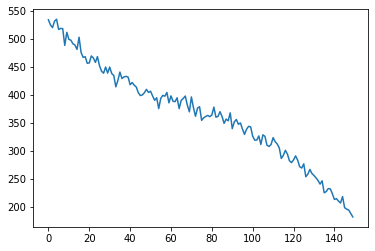

In [7]:
size_of_training_set = 50000
x_training_set = np.random.normal(0.0, sigma, size=(size_of_training_set, dim))
print("Mean:", np.mean(x_training_set), "St. dev.: ", np.std(x_training_set))
loss_vals_1 = bg.train(x_training_set, weight_ML=1, weight_KL=0, iterations=150, batch_size=500)
plt.plot(loss_vals_1["loss"])

Iteration 0/200: loss: 176.8682 ML_loss: 183.0762 KL_loss: -6.2080 
Iteration 10/200: loss: 144.4469 ML_loss: 151.9560 KL_loss: -7.5091 
Iteration 20/200: loss: 113.1424 ML_loss: 122.0001 KL_loss: -8.8578 
Iteration 30/200: loss: 90.5598 ML_loss: 100.7556 KL_loss: -10.1959 
Iteration 40/200: loss: 69.7123 ML_loss: 81.1285 KL_loss: -11.4162 
Iteration 50/200: loss: 49.0933 ML_loss: 61.7282 KL_loss: -12.6348 
Iteration 60/200: loss: 40.7641 ML_loss: 54.4175 KL_loss: -13.6534 
Iteration 70/200: loss: 32.1567 ML_loss: 46.7853 KL_loss: -14.6287 
Iteration 80/200: loss: 25.1976 ML_loss: 40.6639 KL_loss: -15.4663 
Iteration 90/200: loss: 19.5951 ML_loss: 35.7162 KL_loss: -16.1210 
Iteration 100/200: loss: 16.9594 ML_loss: 33.4775 KL_loss: -16.5181 
Iteration 110/200: loss: 14.6033 ML_loss: 31.6117 KL_loss: -17.0084 
Iteration 120/200: loss: 13.2375 ML_loss: 30.3720 KL_loss: -17.1345 
Iteration 130/200: loss: 12.6079 ML_loss: 29.8197 KL_loss: -17.2118 
Iteration 140/200: loss: 11.7784 ML_loss:

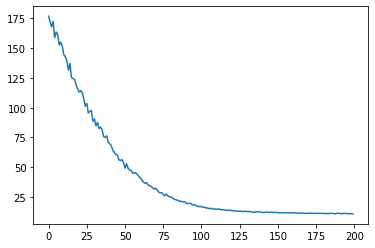

In [8]:
loss_vals_2 = bg.train(x_training_set, weight_ML=1, weight_KL=1, iterations=200, batch_size=1000, verbose=True)
plt.plot(loss_vals_2["loss"])

## Evaluate quality of BG as sampler

In [9]:
n_samples = 100000
sample = bg.sample(n_samples)[1]
coordinate = np.random.choice(np.arange(dim))
print("Chosen coordinate:", coordinate)
x = sample[:,coordinate]
print("Mean:", np.mean(x), "St. dev.:", np.std(x))

Chosen coordinate: 0
Mean: -0.050431684 St. dev.: 9.807049


Fit properties: 
Mean: -0.07863590145180653 
Amplitude: 2314.216896791292 
Standard deviation: 9.804178652699967


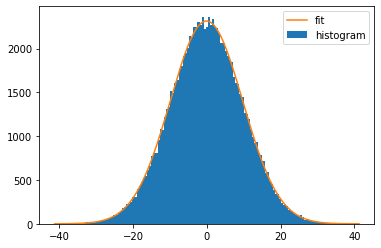

In [10]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / ( 2 * standard_deviation**2))

bin_heights, bin_borders, _ = plt.hist(x, bins='auto', label='histogram')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.legend()
print("Fit properties:", "\nMean:", popt[0], "\nAmplitude:", popt[1], "\nStandard deviation:", popt[2])